In [21]:
#ライブラリのインポート
import os
import glob
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
import joblib
from tqdm import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from torch.utils.data import random_split, DataLoader

In [22]:
def create_windows(data, window_size=20, stride=1):
    windows = []
    for i in range(0, len(data) - window_size + 1, stride):
        windows.append(data[i:i+window_size])
    return np.array(windows)


class StandardizedMotionDataset(Dataset):
    def __init__(self, data_dir, scaler_path=None, window_size=20, stride=1, save_scaler=False):
        self.window_size = window_size
        self.feature_dim = 99
        all_windows = []

        csv_files = glob.glob(os.path.join(data_dir, "*.csv"))
        for path in csv_files:
            df = pd.read_csv(path)
            data = df.select_dtypes(include=[np.number]).values.astype(np.float32)
            windows = create_windows(data, window_size, stride)
            all_windows.extend(windows)

        all_windows = np.array(all_windows)
        N, T, D = all_windows.shape
        flat = all_windows.reshape(-1, D)

        # スケーラー処理
        if save_scaler:
            scaler = StandardScaler()
            flat_scaled = scaler.fit_transform(flat)

            if scaler_path:
                # ディレクトリを自動作成（存在しない場合）
                os.makedirs(os.path.dirname(scaler_path), exist_ok=True)
                joblib.dump(scaler, scaler_path)
        else:
            if scaler_path is None or not os.path.exists(scaler_path):
                raise ValueError("スケーラーの読み込みに失敗しました。パスを確認してください。")
            scaler = joblib.load(scaler_path)
            flat_scaled = scaler.transform(flat)

        self.scaled_data = torch.tensor(flat_scaled.reshape(N, T, D), dtype=torch.float32)

    def __len__(self):
        return len(self.scaled_data)

    def __getitem__(self, idx):
        return self.scaled_data[idx]


In [23]:
dataset = StandardizedMotionDataset(
    data_dir="../data/normalized_features/0814",
    scaler_path="../models/lstm_ae/scaler.joblib",
    save_scaler=True
)


In [24]:
# 2. モデル定義（修正済み）
class LSTMAutoEncoder(nn.Module):
    def __init__(self, input_dim=99, hidden_dim=128, latent_dim=8):
        super().__init__()
        # Encoder
        self.encoder_lstm = nn.LSTM(input_dim, hidden_dim, batch_first=True)
        self.to_latent = nn.Linear(hidden_dim, latent_dim)

        # Decoder
        self.from_latent = nn.Linear(latent_dim, hidden_dim)
        self.decoder_lstm = nn.LSTM(hidden_dim, hidden_dim, batch_first=True)
        self.output_layer = nn.Linear(hidden_dim, input_dim)

    def forward(self, x):
        # Encode
        _, (h_n, _) = self.encoder_lstm(x)    # h_n: [1, B, hidden_dim]
        h_last = h_n[-1]                      # h_last: [B, hidden_dim]
        z = self.to_latent(h_last)           # z: [B, latent_dim]

        # Decode
        h_dec = self.from_latent(z)          # [B, hidden_dim]
        h_dec_seq = h_dec.unsqueeze(1).repeat(1, x.size(1), 1)  # [B, T, hidden_dim]
        dec_out, _ = self.decoder_lstm(h_dec_seq)              # [B, T, hidden_dim]
        recon = self.output_layer(dec_out)                     # [B, T, input_dim]

        return recon, z


In [25]:
def train(model, train_loader, val_loader=None, epochs=10, lr=1e-3, device='cpu', save_path=None):
    model.to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    best_val_loss = float('inf')  # 検証ロス最小値
    best_model_state = None       # 最良モデルの重み

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for batch in train_loader:
            batch = batch.to(device)
            optimizer.zero_grad()
            output, _ = model(batch)
            loss = criterion(output, batch)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        avg_loss = total_loss / len(train_loader)

        # 検証
        if val_loader:
            model.eval()
            val_loss = 0
            with torch.no_grad():
                for val_batch in val_loader:
                    val_batch = val_batch.to(device)
                    recon, _ = model(val_batch)
                    loss = criterion(recon, val_batch)
                    val_loss += loss.item()
            avg_val_loss = val_loss / len(val_loader)
            print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_loss:.6f}, Val Loss: {avg_val_loss:.6f}")

            # 最良モデルを保存
            if save_path and avg_val_loss < best_val_loss:
                best_val_loss = avg_val_loss
                best_model_state = model.state_dict()
        else:
            print(f"Epoch {epoch+1}/{epochs}, Train Loss: {avg_loss:.6f}")

    # 保存処理（最後に一回だけ）
    if save_path and best_model_state:
        torch.save(best_model_state, save_path)
        print(f"✅ 最良モデルを保存しました: {save_path}")


In [56]:
# データセット作成
dataset = StandardizedMotionDataset(
    data_dir="../data/normalized_features/0814",
    scaler_path="../models/lstm_ae/scaler.joblib",
    save_scaler=True
)

# 訓練・検証に分割
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# データローダー定義
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# モデル定義
model = LSTMAutoEncoder()

# 学習＆保存
train(
    model,
    train_loader,
    val_loader=val_loader,
    epochs=30,
    lr=1e-3,
    device='cpu',
    save_path="../models/lstm_0814/lstm_0814_model.pt"
)


Epoch 1/30, Train Loss: 0.427316, Val Loss: 0.238004
Epoch 2/30, Train Loss: 0.242639, Val Loss: 0.215697
Epoch 3/30, Train Loss: 0.223049, Val Loss: 0.194415
Epoch 4/30, Train Loss: 0.201761, Val Loss: 0.174061
Epoch 5/30, Train Loss: 0.178759, Val Loss: 0.154210
Epoch 6/30, Train Loss: 0.158335, Val Loss: 0.133581
Epoch 7/30, Train Loss: 0.140437, Val Loss: 0.126035
Epoch 8/30, Train Loss: 0.136546, Val Loss: 0.125813
Epoch 9/30, Train Loss: 0.123438, Val Loss: 0.112736
Epoch 10/30, Train Loss: 0.119585, Val Loss: 0.108567
Epoch 11/30, Train Loss: 0.111171, Val Loss: 0.107633
Epoch 12/30, Train Loss: 0.115585, Val Loss: 0.102560
Epoch 13/30, Train Loss: 0.113285, Val Loss: 0.096060
Epoch 14/30, Train Loss: 0.097991, Val Loss: 0.094084
Epoch 15/30, Train Loss: 0.098125, Val Loss: 0.089652
Epoch 16/30, Train Loss: 0.087868, Val Loss: 0.084591
Epoch 17/30, Train Loss: 0.093347, Val Loss: 0.085556
Epoch 18/30, Train Loss: 0.084285, Val Loss: 0.087695
Epoch 19/30, Train Loss: 0.082010, Va

In [27]:
#4 潜在ベクトル抽出
def extract_latents(model, dataloader, save_path):
    model.eval()
    all_latents = []
    with torch.no_grad():
        for batch in dataloader:
            _, z = model(batch)
            all_latents.append(z)
    z_all = torch.cat(all_latents, dim=0).numpy()
    latent_df = pd.DataFrame(z_all, columns=[f"z{i+1}" for i in range(z_all.shape[1])])
    latent_df.to_csv(save_path, index=False)
    print(f"Latent vectors saved to: {save_path}")


In [28]:
class MotionWindowDataset(Dataset):
    def __init__(self, data, scaler, window_size=20, stride=1):
        windows = create_windows(data, window_size, stride)  # ウィンドウ分割
        N, T, D = windows.shape

        # 標準化（scalerを使って各ウィンドウを正規化）
        flat = windows.reshape(-1, D)
        scaled = scaler.transform(flat)

        # PyTorch tensor に変換
        self.data = torch.tensor(scaled.reshape(N, T, D), dtype=torch.float32)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]


In [29]:
from pathlib import Path

def extract_latent_lstm_ae_all(
    model_path,
    scaler_path,
    input_dir,
    output_dir,
    input_dim=99,
    latent_dim=8,
    window_size=20,
    stride=1,
    device="cpu"
):
    model_path = Path(model_path)
    scaler_path = Path(scaler_path)
    input_dir = Path(input_dir)
    output_dir = Path(output_dir)

    #from model import LSTMAutoEncoder  # あるいはノートブック内に定義済み

    scaler = joblib.load(scaler_path)
    model = LSTMAutoEncoder(input_dim=input_dim, latent_dim=latent_dim)
    model.load_state_dict(torch.load(model_path, map_location=device))
    model.to(device)
    model.eval()

    output_dir.mkdir(parents=True, exist_ok=True)

    for file_path in input_dir.glob("*.csv"):
        try:
            df = pd.read_csv(file_path)
            data = df.select_dtypes(include=[np.number]).values.astype(np.float32)

            dataset = MotionWindowDataset(data, scaler, window_size, stride)
            dataloader = DataLoader(dataset, batch_size=32, shuffle=False)

            all_z = []
            with torch.no_grad():
                for batch in dataloader:
                    batch = batch.to(device)
                    _, z = model(batch)
                    all_z.append(z.cpu())

            z_all = torch.cat(all_z, dim=0).numpy()
            latent_df = pd.DataFrame(z_all, columns=[f"z{i+1}" for i in range(latent_dim)])

            output_name = file_path.stem + "_latent.csv"
            output_path = output_dir / output_name
            latent_df.to_csv(output_path, index=False)

        except Exception as e:
            print(f"❌ Error processing {file_path.name}: {e}")

    print("✅ 潜在変数の抽出が完了しました。")


In [30]:
extract_latent_lstm_ae_all(
    model_path="../models/lstm_0814/lstm_ae_model.pt",
    scaler_path="../models/lstm_0814/scaler.joblib",
    input_dir="../data/normalized_features/0814",
    output_dir="../data/lstm_latent_0814",
    device="cpu"
)


✅ 潜在変数の抽出が完了しました。


In [31]:
# -----------------------
# 5. 相関可視化
# -----------------------

def compute_correlation(latent_path, input_path):
    df_z = pd.read_csv(latent_path)
    df_x = pd.read_csv(input_path)
    corr = pd.concat([df_z, df_x], axis=1).corr().loc[df_z.columns, df_x.columns]
    plt.figure(figsize=(16, 6))
    sns.heatmap(corr, cmap="coolwarm", center=0)
    plt.title("Correlation between Latent Variables and Input Features")
    plt.tight_layout()
    plt.show()


In [32]:
#全z/xのファイルを読み込んで縦に結合する
from pathlib import Path
import pandas as pd

def merge_all_latent_and_input(latent_dir, input_dir):
    latent_dir = Path(latent_dir)
    input_dir = Path(input_dir)

    all_z = []
    all_x = []

    for latent_file in latent_dir.glob("*_latent.csv"):
        # 対応する元データファイル名
        stem = latent_file.stem.replace("_latent", "")
        input_file = input_dir / f"{stem}.csv"

        if not input_file.exists():
            print(f"⚠️ 対応する入力ファイルが見つかりません: {input_file}")
            continue

        # 読み込み
        df_z = pd.read_csv(latent_file)
        df_x = pd.read_csv(input_file)

        # frame列を除外して数値列だけ残す
        df_x = df_x.select_dtypes(include='number')

        # 長さが合うように調整（ウィンドウで短くなってる）
        min_len = min(len(df_z), len(df_x))
        all_z.append(df_z.iloc[:min_len])
        all_x.append(df_x.iloc[:min_len])

    # 縦方向に連結
    z_concat = pd.concat(all_z, ignore_index=True)
    x_concat = pd.concat(all_x, ignore_index=True)

    return z_concat, x_concat


In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

def compute_correlation_across_all(latent_dir, input_dir):
    df_z, df_x = merge_all_latent_and_input(latent_dir, input_dir)

    # 相関行列（z行 × x列）
    corr = pd.concat([df_z, df_x], axis=1).corr().loc[df_z.columns, df_x.columns]

    # 描画
    plt.figure(figsize=(18, 6))
    sns.heatmap(corr, cmap="coolwarm", center=0)
    plt.title("Correlation between Latent Variables and Input Features (All Files)")
    plt.tight_layout()
    plt.show()


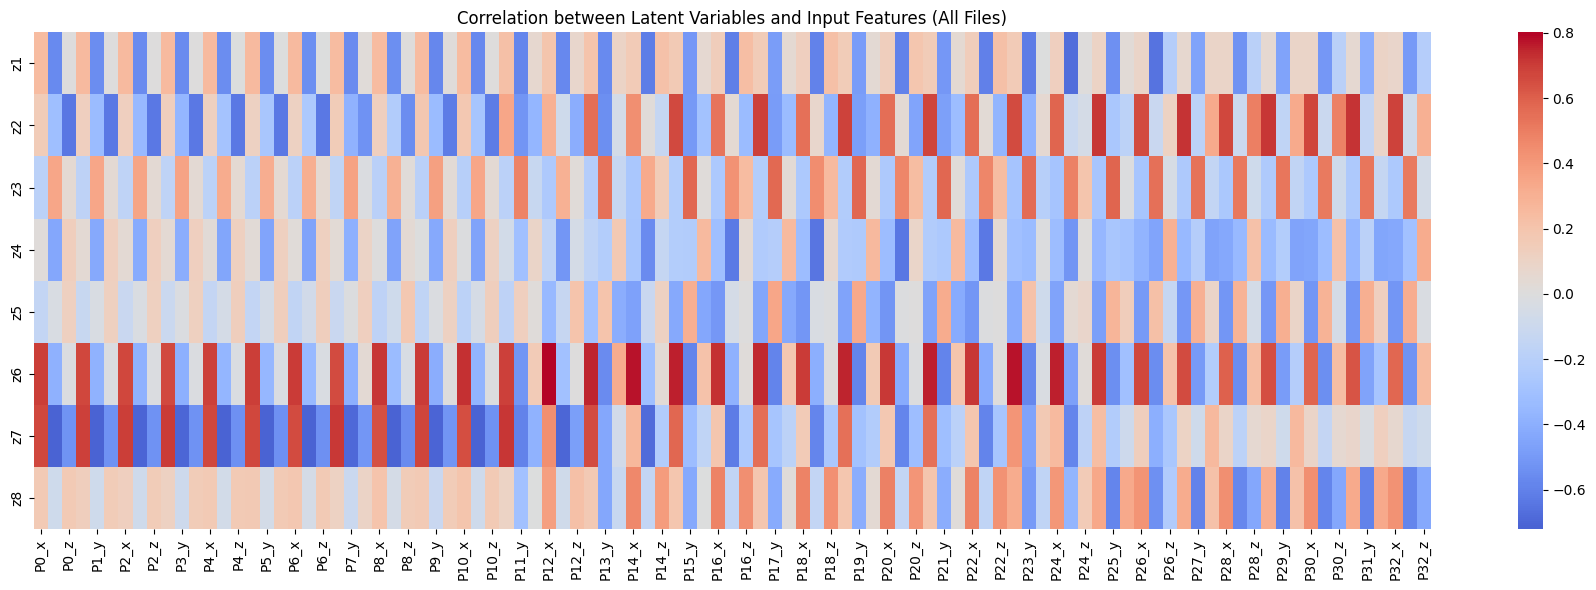

In [34]:
compute_correlation_across_all(
    latent_dir="../data/lstm_latent_0814/",
    input_dir="../data/normalized_features/0814/"
)


In [35]:
import pandas as pd
from pathlib import Path

def load_all_latents(latent_dir):
    latent_dir = Path(latent_dir)
    all_latents = []

    for file in latent_dir.glob("*.csv"):
        df = pd.read_csv(file)
        # 数値列だけ残す（もしファイル名とかが入ってる場合を除外）
        df = df.select_dtypes(include="number")
        all_latents.append(df)

    latent_df = pd.concat(all_latents, ignore_index=True)
    return latent_df

# 実行例
latent_df = load_all_latents("../data/lstm_latent_0814/")
print(latent_df.shape)
latent_df.head()


(3890, 8)


z1        z2        z3        z4        z5        z6        z7  \
0  0.151816 -0.378418  0.129261  0.419405  0.122637 -0.644360  2.048574   
1  0.192790 -0.377044  0.116637  0.310142  0.136053 -0.695882  2.103485   
2  0.228182 -0.385694 -0.043255  0.275271  0.013327 -0.745903  2.176466   
3  0.147454 -0.399314 -0.228885  0.416289 -0.160457 -0.669309  2.145487   
4  0.132056 -0.453229 -0.266548  0.457634 -0.159940 -0.615686  2.109562   

         z8  
0  0.800660  
1  0.800894  
2  0.671493  
3  0.497793  
4  0.423252

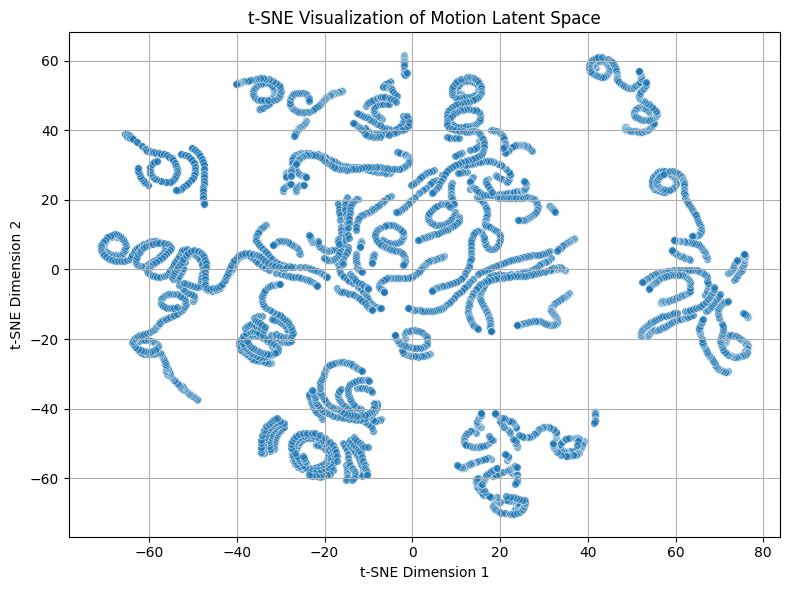

In [36]:
import pandas as pd
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

# 2. t-SNEで2次元に圧縮
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_result = tsne.fit_transform(latent_df.values)

# 3. 可視化
tsne_df = pd.DataFrame(tsne_result, columns=['x', 'y'])

plt.figure(figsize=(8,6))
sns.scatterplot(data=tsne_df, x='x', y='y', s=30, alpha=0.7)
plt.title("t-SNE Visualization of Motion Latent Space")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.grid(True)
plt.tight_layout()
plt.show()


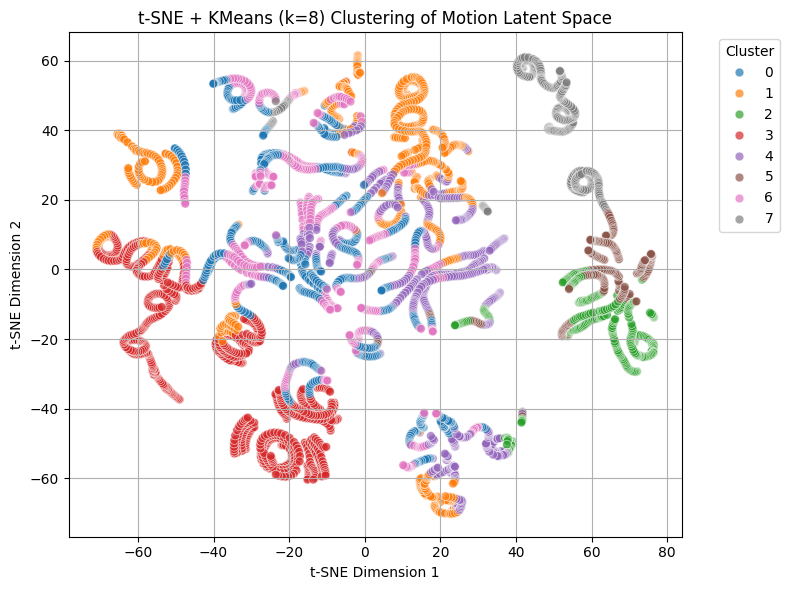

In [37]:
import pandas as pd
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns

# 2. KMeansクラスタリング（例：8クラスタ）
k = 8
kmeans = KMeans(n_clusters=k, random_state=42)
cluster_ids = kmeans.fit_predict(latent_df.values)

# 3. t-SNEで2次元化（再度）
tsne = TSNE(n_components=2, perplexity=30, random_state=42)
tsne_result = tsne.fit_transform(latent_df.values)

# 4. 可視化用データ整形
tsne_df = pd.DataFrame(tsne_result, columns=['x', 'y'])
tsne_df['cluster'] = cluster_ids

# 5. 色分け可視化
plt.figure(figsize=(8,6))
sns.scatterplot(data=tsne_df, x='x', y='y', hue='cluster', palette='tab10', s=40, alpha=0.7)
plt.title(f"t-SNE + KMeans (k={k}) Clustering of Motion Latent Space")
plt.xlabel("t-SNE Dimension 1")
plt.ylabel("t-SNE Dimension 2")
plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.grid(True)
plt.tight_layout()
plt.show()


In [38]:
from pathlib import Path
import pandas as pd

def build_latent_vectors_csv(latent_dir, output_path):
    latent_dir = Path(latent_dir)
    all_latents = []

    for latent_file in latent_dir.glob("*_latent.csv"):
        df = pd.read_csv(latent_file)

        # ウィンドウ番号を追加
        df["window"] = range(len(df))

        # 元ファイル名を保存（拡張子含む or 除くはお好みで）
        df["source"] = latent_file.stem.replace("_latent", "") + ".csv"

        all_latents.append(df)

    # 全部まとめて1つの DataFrame に
    all_df = pd.concat(all_latents, ignore_index=True)

    # 保存
    output_path = Path(output_path)
    output_path.parent.mkdir(parents=True, exist_ok=True)
    all_df.to_csv(output_path, index=False)

    print(f"✅ latent_vectors.csv を保存しました → {output_path}")


In [39]:
build_latent_vectors_csv(
    latent_dir="../data/lstm_latent_0814/",
    output_path="../data/latent_vectors.csv"
)


✅ latent_vectors.csv を保存しました → ..\data\latent_vectors.csv


In [40]:
df = pd.read_csv("../data/latent_vectors.csv")
df.head()

z1        z2        z3        z4        z5        z6        z7  \
0  0.151816 -0.378418  0.129261  0.419405  0.122637 -0.644360  2.048574   
1  0.192790 -0.377044  0.116637  0.310142  0.136053 -0.695882  2.103485   
2  0.228182 -0.385694 -0.043255  0.275271  0.013327 -0.745903  2.176466   
3  0.147454 -0.399314 -0.228885  0.416289 -0.160457 -0.669309  2.145487   
4  0.132056 -0.453229 -0.266548  0.457634 -0.159940 -0.615686  2.109562   

         z8  window  source  
0  0.800660       0  久世.csv  
1  0.800894       1  久世.csv  
2  0.671493       2  久世.csv  
3  0.497793       3  久世.csv  
4  0.423252       4  久世.csv

In [41]:
import pandas as pd
from sklearn.cluster import KMeans

def add_cluster_labels(latent_path, k=8, output_path=None):
    df = pd.read_csv(latent_path)

    # z1〜z8 だけ取り出してクラスタリング
    z_columns = [col for col in df.columns if col.startswith("z")]
    z_values = df[z_columns].values

    kmeans = KMeans(n_clusters=k, random_state=42)
    cluster_ids = kmeans.fit_predict(z_values)

    # cluster列を追加
    df["cluster"] = cluster_ids

    # 保存
    if output_path is None:
        output_path = latent_path  # 上書き保存

    df.to_csv(output_path, index=False)
    print(f"✅ cluster列を追加して保存しました → {output_path}")

    return df.head()


In [42]:
add_cluster_labels(
    latent_path="../data/latent_vectors.csv",
    k=8,
    output_path="../data/latent_vectors.csv"  # 上書き保存
)


✅ cluster列を追加して保存しました → ../data/latent_vectors.csv


z1        z2        z3        z4        z5        z6        z7  \
0  0.151816 -0.378418  0.129261  0.419405  0.122637 -0.644360  2.048574   
1  0.192790 -0.377044  0.116637  0.310142  0.136053 -0.695882  2.103485   
2  0.228182 -0.385694 -0.043255  0.275271  0.013327 -0.745903  2.176466   
3  0.147454 -0.399314 -0.228885  0.416289 -0.160457 -0.669309  2.145487   
4  0.132056 -0.453229 -0.266548  0.457634 -0.159940 -0.615686  2.109562   

         z8  window  source  cluster  
0  0.800660       0  久世.csv        4  
1  0.800894       1  久世.csv        4  
2  0.671493       2  久世.csv        4  
3  0.497793       3  久世.csv        4  
4  0.423252       4  久世.csv        4

In [43]:
#クラスタリング結果の可視化
import pandas as pd
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import seaborn as sns

def visualize_latent_clusters(latent_path, perplexity=40):
    df = pd.read_csv(latent_path)

    if "cluster" not in df.columns:
        raise ValueError("cluster列がありません。まずKMeansでクラスタを追加してください。")

    z_columns = [col for col in df.columns if col.startswith("z")]
    z_values = df[z_columns].values

    # t-SNEで2次元に圧縮
    tsne = TSNE(n_components=2, perplexity=perplexity, random_state=42)
    tsne_result = tsne.fit_transform(z_values)

    # 可視化用DataFrame作成
    vis_df = pd.DataFrame(tsne_result, columns=["x", "y"])
    vis_df["cluster"] = df["cluster"].astype(str)  # 色分け用にstrにするのもおすすめ

    # プロット
    plt.figure(figsize=(10, 7))
    sns.scatterplot(data=vis_df, x="x", y="y", hue="cluster", palette="tab10", s=40, alpha=0.7)
    plt.title("t-SNE Visualization of Latent Space (Colored by Cluster)")
    plt.xlabel("t-SNE Dimension 1")
    plt.ylabel("t-SNE Dimension 2")
    plt.legend(title="Cluster", bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


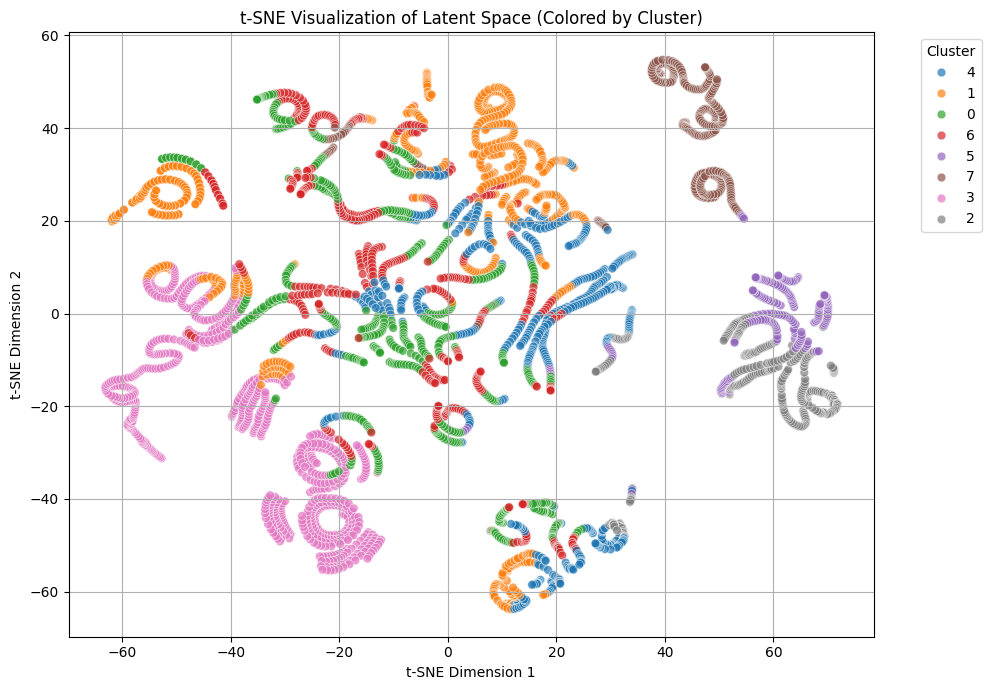

In [44]:
visualize_latent_clusters("../data/latent_vectors.csv")

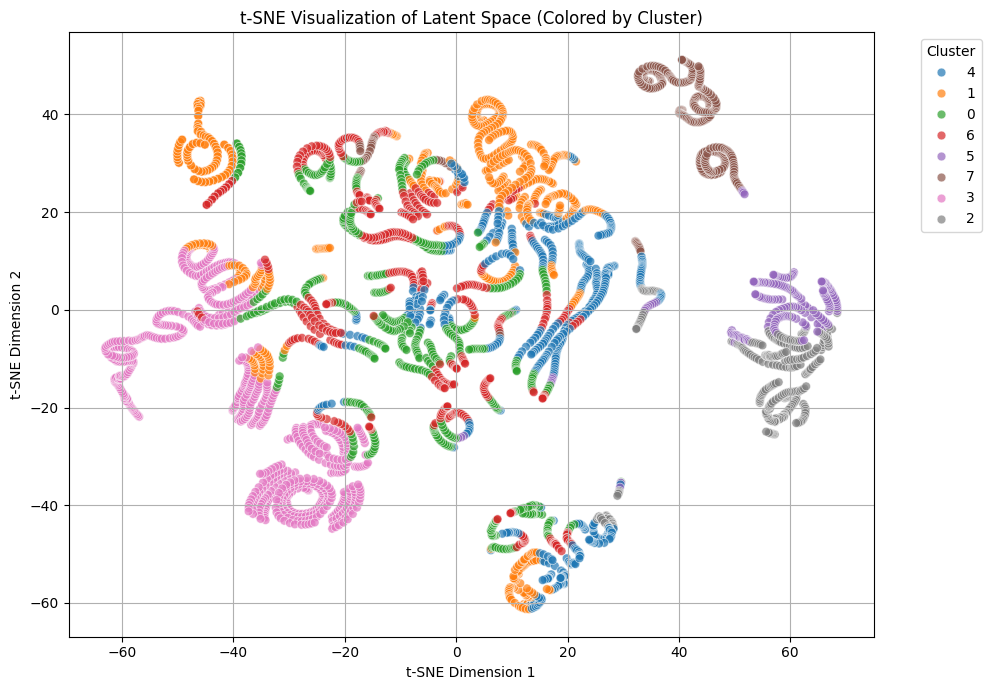

In [45]:
visualize_latent_clusters("../data/latent_vectors.csv",perplexity=50)


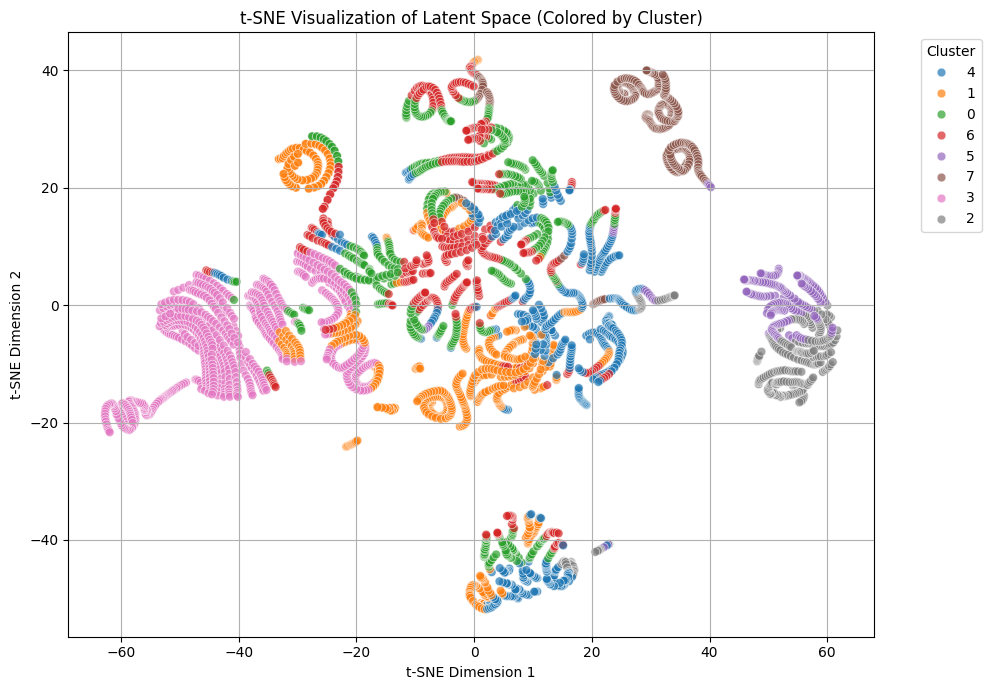

In [46]:
visualize_latent_clusters("../data/latent_vectors.csv",perplexity=80)


In [47]:
#クラスタ代表を3件ずつ抽出
import pandas as pd
import random

def extract_cluster_representatives(latent_path, n_per_cluster=3):
    df = pd.read_csv(latent_path)

    if "cluster" not in df.columns:
        raise ValueError("クラスタ列がありません")

    reps = []
    for cluster_id in sorted(df["cluster"].unique()):
        subset = df[df["cluster"] == cluster_id]
        sampled = subset.sample(n=min(n_per_cluster, len(subset)), random_state=42)
        reps.append(sampled)

    reps_df = pd.concat(reps, ignore_index=True)
    reps_df.to_csv("../data/cluster_representatives.csv", index=False)
    print("✅ クラスタ代表例を抽出しました → cluster_representatives.csv")
    return reps_df


In [48]:
import cv2
from pathlib import Path

def find_existing_video_file(video_dir, base_name):
    """指定されたベース名に対して、実在する動画ファイル（.mp4/.movなど）を探す"""
    extensions = [".mp4", ".MP4", ".mov", ".MOV"]
    for ext in extensions:
        candidate = Path(video_dir) / (base_name + ext)
        if candidate.exists():
            return candidate
    return None

def extract_video_windows(
    reps_df,
    video_dir="../data/動画データ_ver2",
    output_dir="../output/clips",
    window_size=20,
    stride=1,
    resize=(256, 256)
):
    output_dir = Path(output_dir)
    output_dir.mkdir(parents=True, exist_ok=True)

    for idx, row in reps_df.iterrows():
        base_name = row["source"].replace(".csv", "")  # 例："水谷2人目_嬉しい"
        window = int(row["window"])
        cluster = int(row["cluster"])

        # 動画ファイル探索
        video_path = find_existing_video_file(video_dir, base_name)
        if video_path is None:
            print(f"❌ 該当する動画が見つかりません: {base_name}（tried: mp4/mov）")
            continue

        start_frame = window * stride
        end_frame = start_frame + window_size

        cap = cv2.VideoCapture(str(video_path))
        if not cap.isOpened():
            print(f"❌ ファイルが開けません（OpenCVエラー）: {video_path}")
            continue

        # 出力動画ファイル名
        out_path = output_dir / f"{base_name}_cluster{cluster}_win{window}.mp4"
        fps = cap.get(cv2.CAP_PROP_FPS)
        fourcc = cv2.VideoWriter_fourcc(*"mp4v")
        out = cv2.VideoWriter(str(out_path), fourcc, fps, resize)

        frame_idx = 0
        written = 0
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break

            if start_frame <= frame_idx < end_frame:
                frame = cv2.resize(frame, resize)
                out.write(frame)
                written += 1

            frame_idx += 1
            if frame_idx >= end_frame:
                break

        cap.release()
        out.release()
        print(f"🎞️ 切り出し成功: {out_path}（{written}フレーム）")


In [49]:
# ステップ①: 代表例の抽出
reps_df = extract_cluster_representatives("../data/latent_vectors.csv", n_per_cluster=3)

# ステップ②: 動画クリップとして保存
extract_video_windows(reps_df)


✅ クラスタ代表例を抽出しました → cluster_representatives.csv
🎞️ 切り出し成功: ..\output\clips\十河2人目緊張VID20250616120010_cluster0_win61.mp4（20フレーム）
🎞️ 切り出し成功: ..\output\clips\水谷2人目_リラックス_cluster0_win168.mp4（20フレーム）
🎞️ 切り出し成功: ..\output\clips\十河1人目嬉しいVID20250616115335_cluster0_win49.mp4（20フレーム）
🎞️ 切り出し成功: ..\output\clips\水谷1人目_緊張_cluster1_win86.mp4（20フレーム）
🎞️ 切り出し成功: ..\output\clips\水谷1人目_悲しい_cluster1_win47.mp4（20フレーム）
🎞️ 切り出し成功: ..\output\clips\十河4人目悲しいVID20250616120318_cluster1_win30.mp4（20フレーム）
🎞️ 切り出し成功: ..\output\clips\比嘉2人目緊張_cluster2_win13.mp4（20フレーム）
🎞️ 切り出し成功: ..\output\clips\比嘉2人目緊張_cluster2_win62.mp4（20フレーム）
🎞️ 切り出し成功: ..\output\clips\比嘉2人目悲しい_cluster2_win17.mp4（20フレーム）
🎞️ 切り出し成功: ..\output\clips\水谷2人目_嬉しい_cluster3_win159.mp4（20フレーム）
🎞️ 切り出し成功: ..\output\clips\水谷2人目_緊張_cluster3_win128.mp4（20フレーム）
🎞️ 切り出し成功: ..\output\clips\水谷2人目_嬉しい_cluster3_win57.mp4（20フレーム）
🎞️ 切り出し成功: ..\output\clips\十河_cluster4_win96.mp4（20フレーム）
🎞️ 切り出し成功: ..\output\clips\十河4人目悲しいVID20250616120318_cluster4_win58.mp4（20フレーム）
🎞️ 

In [50]:
#確認用：1フレームだけ表示させる
import cv2
from pathlib import Path
import matplotlib.pyplot as plt

def check_video_orientation(video_path):
    video_path = Path(video_path)
    cap = cv2.VideoCapture(str(video_path))

    if not cap.isOpened():
        print(f"❌ ファイルが開けません: {video_path}")
        return

    ret, frame = cap.read()
    cap.release()

    if not ret:
        print("❌ フレームの読み込みに失敗しました")
        return

    # BGR → RGB に変換（matplotlib表示用）
    frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(6, 4))
    plt.imshow(frame_rgb)
    plt.title(f"Preview: {video_path.name}")
    plt.axis("off")
    plt.show()


c:\Users\21td031\Documents\motion2music\venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 27700 (\N{CJK UNIFIED IDEOGRAPH-6C34}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\21td031\Documents\motion2music\venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 35895 (\N{CJK UNIFIED IDEOGRAPH-8C37}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\21td031\Documents\motion2music\venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 20154 (\N{CJK UNIFIED IDEOGRAPH-4EBA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\21td031\Documents\motion2music\venv\lib\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 30446 (\N{CJK UNIFIED IDEOGRAPH-76EE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
c:\Users\21td031\Documents\motion2music\venv\lib\site-packages\IPython\core\pylabtoo

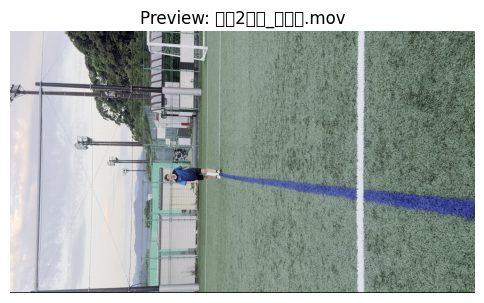

In [51]:
check_video_orientation("../data/動画データ_ver2/水谷2人目_嬉しい.mov")


In [52]:
#OpenCVで1フレームずつサムネイルを表示する
import cv2
from pathlib import Path
import matplotlib.pyplot as plt

def preview_all_videos(video_dir, num_per_row=3):
    video_dir = Path(video_dir)
    video_files = sorted(video_dir.glob("*.*"))  # 拡張子すべて対象（.mp4, .movなど）

    rows = (len(video_files) + num_per_row - 1) // num_per_row
    plt.figure(figsize=(5 * num_per_row, 4 * rows))

    for i, video_path in enumerate(video_files):
        cap = cv2.VideoCapture(str(video_path))
        ret, frame = cap.read()
        cap.release()

        if not ret:
            continue

        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        plt.subplot(rows, num_per_row, i + 1)
        plt.imshow(frame_rgb)
        plt.title(video_path.name, fontsize=10)
        plt.axis("off")

    plt.tight_layout()
    plt.show()


C:\Users\21td031\AppData\Local\Temp\ipykernel_23104\4004942536.py:27: UserWarning: Glyph 20037 (\N{CJK UNIFIED IDEOGRAPH-4E45}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\21td031\AppData\Local\Temp\ipykernel_23104\4004942536.py:27: UserWarning: Glyph 19990 (\N{CJK UNIFIED IDEOGRAPH-4E16}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\21td031\AppData\Local\Temp\ipykernel_23104\4004942536.py:27: UserWarning: Glyph 21313 (\N{CJK UNIFIED IDEOGRAPH-5341}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\21td031\AppData\Local\Temp\ipykernel_23104\4004942536.py:27: UserWarning: Glyph 27827 (\N{CJK UNIFIED IDEOGRAPH-6CB3}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\21td031\AppData\Local\Temp\ipykernel_23104\4004942536.py:27: UserWarning: Glyph 20154 (\N{CJK UNIFIED IDEOGRAPH-4EBA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
C:\Users\21td031\AppData\Local\Temp\ipykernel_23104\4004942536.py:27: UserWarning: Gl

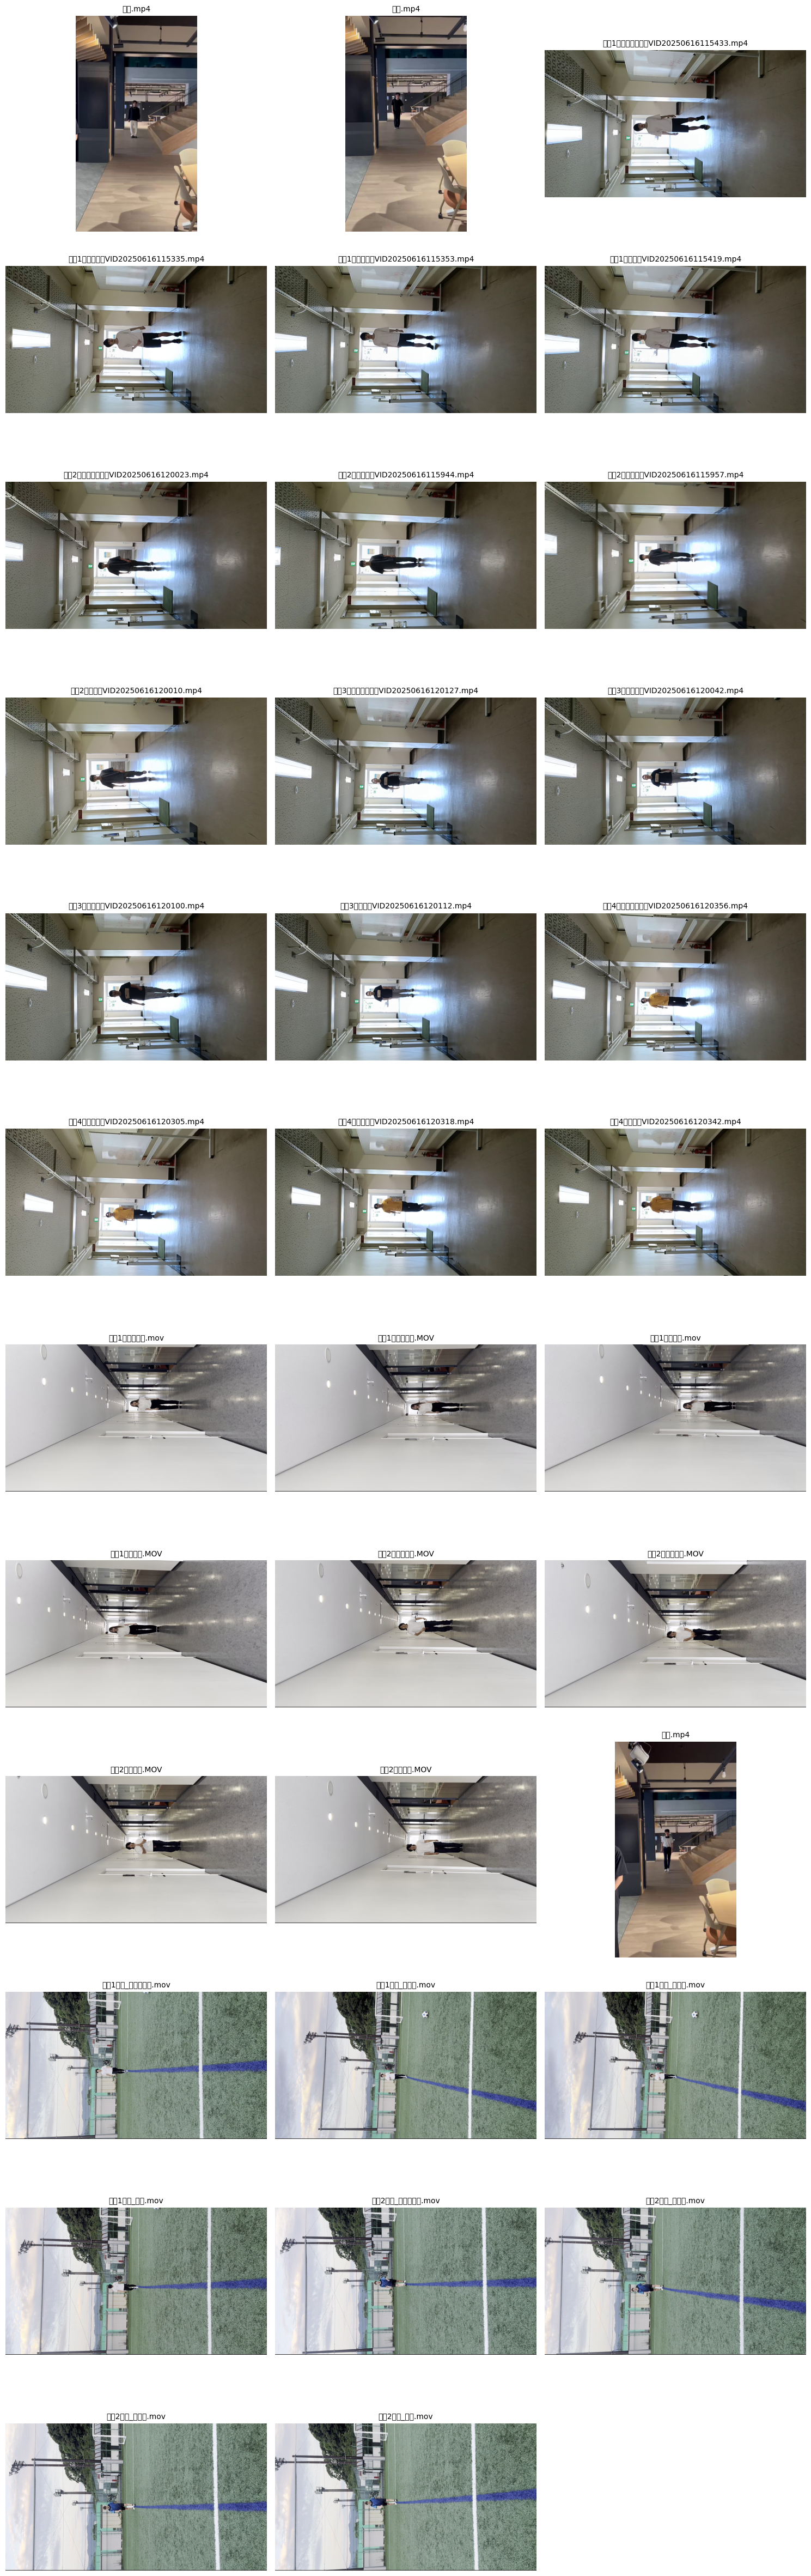

In [53]:
preview_all_videos("../data/動画データ_ver2")


In [54]:
def extract_pose_from_video(video_path, rotate=True):
    cap = cv2.VideoCapture(video_path)
    pose = mp_pose.Pose(static_image_mode=False)
    all_landmarks = []

    while True:
        ret, frame = cap.read()
        if not ret:
            break

        if rotate:
            frame = cv2.rotate(frame, cv2.ROTATE_90_CLOCKWISE)  # ✅ 右に90度回転

        frame_rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        results = pose.process(frame_rgb)

        if results.pose_landmarks:
            frame_data = []
            for lm in results.pose_landmarks.landmark:
                frame_data.extend([lm.x, lm.y, lm.z])
            all_landmarks.append(frame_data)

    cap.release()

    if all_landmarks:
        columns = [f'P{i}_{axis}' for i in range(33) for axis in ('x', 'y', 'z')]
        df = pd.DataFrame(all_landmarks, columns=columns)
        return df
    else:
        print(f"⚠️ No landmarks extracted from {video_path}")
        return None


In [55]:
# 回転不要ファイル名（.csv ではなく動画名ベースに合わせる）
skip_rotation_names = {"久世", "水谷", "十河"}

for video_path in video_paths:
    filename = os.path.splitext(os.path.basename(video_path))[0]
    output_csv_path = os.path.join(output_dir, f"{filename}.csv")

    # ✅ 指定ファイルは回転しない
    rotate = not any(name in filename for name in skip_rotation_names)

    df_raw = extract_pose_from_video(video_path, rotate=rotate)
    if df_raw is not None:
        df_processed = preprocess_pose_dataframe(df_raw)
        df_processed.to_csv(output_csv_path, index=False)
        print(f"✅ 完了: {output_csv_path}")
    else:
        print(f"❌ スキップ: {video_path}")


NameError: name 'video_paths' is not defined